# Spatial Regression Models 

This notebook provides a step-by-step introduction to spatial regression modelling. We demonstrate how to move from a standard OLS regression to spatial econometric models (Spatial Error, Spatial Lag, and Spatial Durbin models) when spatial dependency is detected in the data.

1. Construct standard OLS model
2. Construct spatial weight matrices 
3. Diagnose spatial autocorrelation using Moran's I
4. Apply Lagrange Multiplier (LM) tests and LR test for model selection
5. Estimate and interpret spatial regression models

**Data:** Inside Airbnb listings for Bristol, UK

https://insideairbnb.com/get-the-data/

**Dependent Variable (Y):** Log-transformed listing price

**Question:** * Influencing factors of Airbnb price? 

In [ ]:
pip install watermark

: 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import geopandas as gpd
from libpysal.weights import DistanceBand, KNN
from esda.moran import Moran
from spreg import OLS, ML_Error, ML_Lag, GM_Error, GM_Lag
from scipy import stats
from shapely.geometry import Point
from splot.esda import moran_scatterplot, plot_moran
import contextily as ctx
from matplotlib.ticker import FuncFormatter
import pyproj
from libpysal.weights import lag_spatial

### 1 Load and explore the dataset

In [4]:
df = pd.read_csv(r'Data/listings.csv.gz')

For the spatial regression, we need to select meaningful independent variables (X) that explain listing price (Y), along with coordinates for spatial analysis.


| Variable | Type | Rationale |
|---|---|---|
| `log_price` | Dependent (Y) | Log-transformed listing price per night |
| `accommodates` | Property | Maximum guest capacity |
| `bedrooms` | Property | Number of bedrooms |
| `bathrooms` | Property | Number of bathrooms |
| `room_type` | Property | Entire home vs private room vs shared room (dummy encoded) |
| `is_superhost` | Host | Superhost status as a trust and quality signal |
| `review_scores_rating` | Demand | Overall guest rating as a quality indicator |
| `reviews_per_month` | Demand | Frequency of bookings as a popularity proxy |
| `availability_365` | Supply | Days available per year — supply-side indicator |
| `minimum_nights` | Policy | Minimum stay requirement — booking flexibility |
| `is_instant_bookable` | Policy | Whether guests can book without host approval |

### 2 Clean the variables 

In [5]:
# Clean price 
df['price'] = df['price'].replace(r'[\$,]', '', regex=True).astype(float)

In [6]:
# Select variables
cols = [
    'id', 'latitude', 'longitude', 'price',
    'room_type', 'accommodates', 'bedrooms', 'bathrooms_text',
    'host_is_superhost', 'instant_bookable',
    'reviews_per_month',
    'review_scores_rating',
    'availability_365', 'minimum_nights',
    'neighbourhood_cleansed'
]

df_clean = df[cols].copy()


In [7]:
# ---- Clean bathrooms ----
df_clean['bathrooms'] = df_clean['bathrooms_text'].str.extract(r'(\d+\.?\d*)').astype(float)
df_clean = df_clean.drop(columns='bathrooms_text')

# ---- Encode binary variables ----
df_clean['is_superhost'] = (df_clean['host_is_superhost'] == 't').astype(int)
df_clean['is_instant_bookable'] = (df_clean['instant_bookable'] == 't').astype(int)
df_clean = df_clean.drop(columns=['host_is_superhost', 'instant_bookable'])

# ---- Create room type dummies ----
# Reference category: 'Entire home/apt'
room_dummies = pd.get_dummies(df_clean['room_type'], prefix='room', drop_first=False)

# Keep interpretable dummies (drop 'Entire home/apt' as reference)
if 'room_Entire home/apt' in room_dummies.columns:
    room_dummies = room_dummies.drop(columns='room_Entire home/apt')
df_clean = pd.concat([df_clean, room_dummies], axis=1)

In [8]:
# ---- Drop missing values in key variables ----
key_cols = ['price', 'latitude', 'longitude', 'bedrooms',
            'bathrooms', 'review_scores_rating', 'accommodates',
            'reviews_per_month', 'availability_365', 'minimum_nights',
            'is_superhost', 'is_instant_bookable']
df_clean = df_clean.dropna(subset=key_cols)

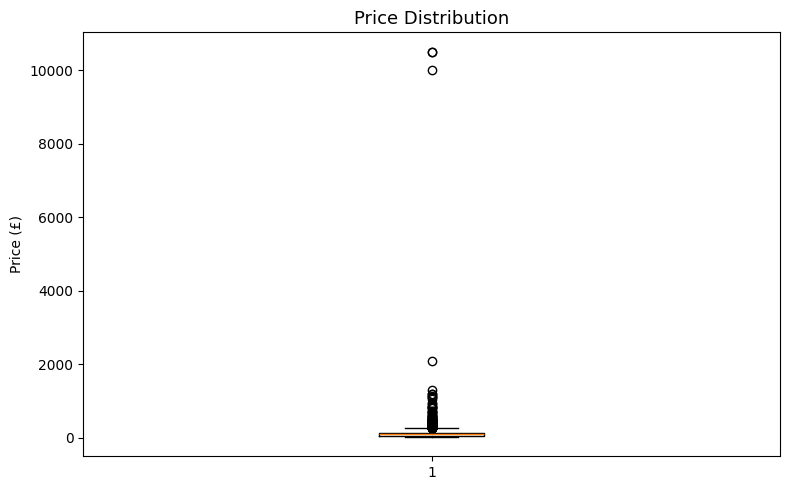

In [9]:
# explore price outliers
fig, ax = plt.subplots(figsize=(8, 5))

ax.boxplot(df_clean['price'], vert=True)
ax.set_title('Price Distribution', fontsize=13)
ax.set_ylabel('Price (£)')

plt.tight_layout()
plt.show()

In [10]:
# ---- Remove price outliers ----
df_clean = df_clean[df_clean['price'] <= 500]
df_clean = df_clean.reset_index(drop=True)
print(f"After removing price > £500: {len(df_clean)}")

After removing price > £500: 1900


In [11]:
# Log-transform price 
df_clean['log_price'] = np.log(df_clean['price'])

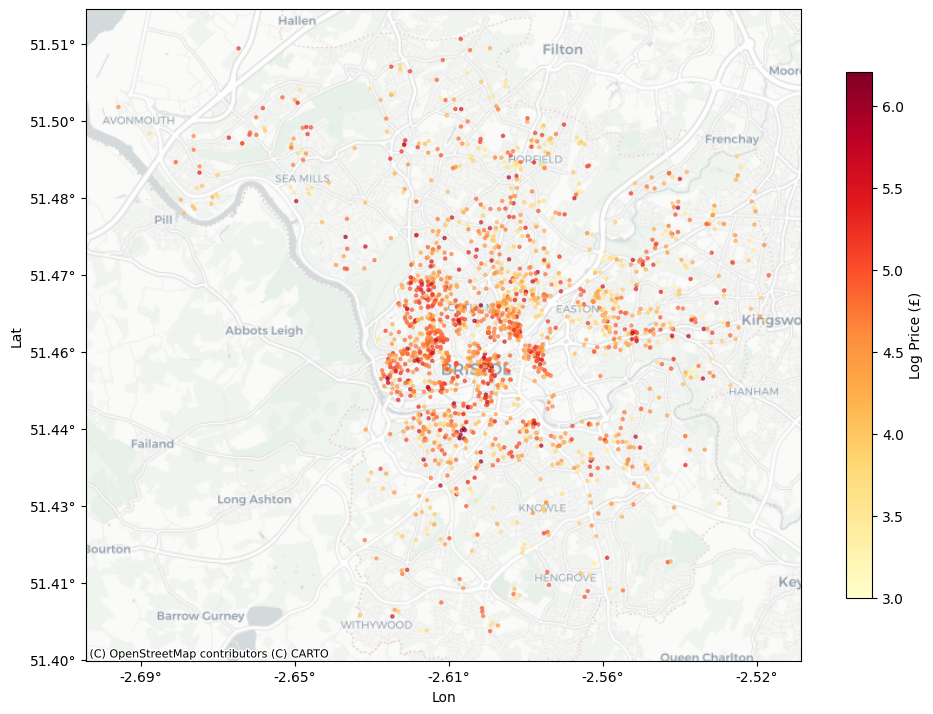

In [12]:

geometry = [Point(xy) for xy in zip(df_clean['longitude'], df_clean['latitude'])]
gdf = gpd.GeoDataFrame(df_clean, geometry=geometry, crs='EPSG:4326')

gdf_web = gdf.to_crs('EPSG:3857')

fig, ax = plt.subplots(figsize=(10, 8))

gdf_web.plot(
    ax=ax, column='log_price', cmap='YlOrRd',
    markersize=5, alpha=0.6, legend=True,
    legend_kwds={'label': 'Log Price (£)', 'shrink': 0.7}
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

ax.set_xlabel('Lon')
ax.set_ylabel('Lat')

transformer = pyproj.Transformer.from_crs('EPSG:3857', 'EPSG:4326', always_xy=True)

def lon_formatter(x, pos):
    lon, _ = transformer.transform(x, 0)
    return f'{lon:.2f}°'

def lat_formatter(y, pos):
    _, lat = transformer.transform(0, y)
    return f'{lat:.2f}°'

ax.xaxis.set_major_formatter(FuncFormatter(lon_formatter))
ax.yaxis.set_major_formatter(FuncFormatter(lat_formatter))

plt.tight_layout()
plt.show()

### 3 Construct the Spatial Weight Matrix ($W$)

The spatial weight matrix $W$ defines the neighbourhood structure — which observations are considered "neighbours" and how strongly they are connected.

For point data, common approaches include:

| Method | Description | When to Use |
|---|---|---|
| **K-Nearest Neighbours (KNN)** | Each point connects to its $k$ nearest neighbours | When you want a fixed number of neighbours |
| **Distance Band** | Points within a threshold distance are neighbours | When spatial interaction decays with distance |

We use **KNN** as the primary weight matrix for the regression models, as it ensures every observation has at least $k$ neighbours (avoiding islands).

In [15]:
# Extract projected coordinates for distance calculations
gdf_proj = gdf.to_crs('EPSG:27700')
coords = np.column_stack((gdf_proj.geometry.x, gdf_proj.geometry.y))

# ---- KNN Weight Matrix ----
w_knn = KNN.from_array(coords, k=5)
w_knn.transform = 'R'  # Row-standardise

print("=== KNN Spatial Weights (k=5) ===")
print(f"Number of observations: {w_knn.n}")
print(f"Mean number of neighbours: {w_knn.mean_neighbors:.1f}")
print(f"Min neighbours: {w_knn.min_neighbors}")
print(f"Max neighbours: {w_knn.max_neighbors}")

=== KNN Spatial Weights (k=5) ===
Number of observations: 1900
Mean number of neighbours: 5.0
Min neighbours: 5
Max neighbours: 5


### 4 Estimate OLS 

We first estimate a standard OLS model as the baseline:

$$Y = X\beta + \epsilon$$

We then examine the residuals for spatial autocorrelation.

In [16]:
# Dependent variable
y_col = 'log_price'
y = df_clean[[y_col]].values

# Independent variables
room_dummy_cols = [c for c in df_clean.columns if c.startswith('room_') and c != 'room_type']

x_cols = [
    'accommodates', 'bedrooms', 'bathrooms',
    'is_superhost', 'review_scores_rating', 'reviews_per_month',
    'availability_365', 'minimum_nights',
    'is_instant_bookable'
] + room_dummy_cols

# Convert room type dummies to int
for col in room_dummy_cols:
    df_clean[col] = df_clean[col].astype(int)

x = df_clean[x_cols].values


In [17]:
# Run OLS
ols = OLS(
    y, x,
    w=w_knn,
    name_y=y_col,
    name_x=x_cols,
    name_ds='Bristol Airbnb',
    spat_diag=True  # Request spatial diagnostics including LM tests
)

print(ols.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :Bristol Airbnb
Weights matrix      :     unknown
Dependent Variable  :   log_price                Number of Observations:        1900
Mean dependent var  :      4.5279                Number of Variables   :          12
S.D. dependent var  :      0.5927                Degrees of Freedom    :        1888
R-squared           :      0.6876
Adjusted R-squared  :      0.6858
Sum squared residual:     208.377                F-statistic           :    377.8501
Sigma-square        :       0.110                Prob(F-statistic)     :           0
S.E. of regression  :       0.332                Log likelihood        :    -596.237
Sigma-square ML     :       0.110                Akaike info criterion :    1216.474
S.E of regression ML:      0.3312                Schwarz criterion     :    1283.069

----------------------------------------------------------

In [19]:
# Moran's I test for spatial autocorrelation in OLS residuals
residuals = ols.u.flatten()
moran = Moran(residuals, w_knn)

print("=== Global Moran's I Test on OLS Residuals ===")
print(f"Moran's I:     {moran.I:.4f}")
print(f"Expected I:    {moran.EI:.4f}")
print(f"Z-score:       {moran.z_sim:.4f}")
print(f"P-value:       {moran.p_sim:.4f}")
print()

=== Global Moran's I Test on OLS Residuals ===
Moran's I:     0.2728
Expected I:    -0.0005
Z-score:       20.5476
P-value:       0.0010



- **Moran's I on residuals**: Is there spatial autocorrelation in the residuals?
- **LM tests**: Which type of spatial model is appropriate?


### 5 Estimate spatial regression model 


Regardless of the LM test outcome, we estimate all three models here for **demonstration and comparison** purposes. In practice, you would focus on the model indicated by the diagnostic tests.


####  Spatial Error Model (SEM)

$$y = X\beta + \mu$$
$$\mu = \lambda W\mu + \epsilon$$

The SEM assumes spatial dependence in the **error terms**. The parameter $\lambda$ captures the strength of spatial autocorrelation among the residuals. This means that unobserved factors affecting price are spatially correlated — e.g., neighbourhood characteristics we haven't included in the model.

In [21]:
sem = ML_Error(
    y, x,
    w=w_knn,
    name_y=y_col,
    name_x=x_cols,
    name_ds='Bristol Airbnb'
)

print(sem.summary)

/Users/zixinfeng/Documents/Coding/.venv/lib/python3.14/site-packages/spreg/ml_error.py:184: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(
/Users/zixinfeng/Documents/Coding/.venv/lib/python3.14/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/zixinfeng/Documents/Coding/.venv/lib/python3.14/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/zixinfeng/Documents/Coding/.venv/lib/python3.14/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ML SPATIAL ERROR (METHOD = full)
---------------------------------------------------
Data set            :Bristol Airbnb
Weights matrix      :     unknown
Dependent Variable  :   log_price                Number of Observations:        1900
Mean dependent var  :      4.5279                Number of Variables   :          12
S.D. dependent var  :      0.5927                Degrees of Freedom    :        1888
Pseudo R-squared    :      0.6831
Log likelihood      :   -454.4581
Sigma-square ML     :      0.0904                Akaike info criterion :     932.916
S.E of regression   :      0.3007                Schwarz criterion     :     999.512

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT         3.77706  

#### Spatial Autoregressive Model (SAR / Spatial Lag Model)

$$y = \rho Wy + X\beta + \epsilon$$

The SAR assumes the dependent variable at one location is directly influenced by the dependent variable at **neighbouring locations**. The parameter $\rho$ captures the strength of the spatial lag effect. For Airbnb, this means a listing's price is directly influenced by what nearby listings charge.

In [22]:
sar = ML_Lag(
    y, x,
    w=w_knn,
    name_y=y_col,
    name_x=x_cols,
    name_ds='Bristol Airbnb'
)

print(sar.summary)


/Users/zixinfeng/Documents/Coding/.venv/lib/python3.14/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/zixinfeng/Documents/Coding/.venv/lib/python3.14/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/zixinfeng/Documents/Coding/.venv/lib/python3.14/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :Bristol Airbnb
Weights matrix      :     unknown
Dependent Variable  :   log_price                Number of Observations:        1900
Mean dependent var  :      4.5279                Number of Variables   :          13
S.D. dependent var  :      0.5927                Degrees of Freedom    :        1887
Pseudo R-squared    :      0.7236
Spatial Pseudo R-squared:  0.6864
Log likelihood      :   -493.2207
Sigma-square ML     :      0.0971                Akaike info criterion :    1012.441
S.E of regression   :      0.3115                Schwarz criterion     :    1084.586

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-------------------------------------------------------------

#### Spatial Durbin Model (SDM)

$$y = \rho Wy + X\beta + WX\theta + \epsilon$$

The SDM is the most general model, including both the spatial lag of $Y$ ($Wy$) and spatial lags of all independent variables ($WX$). It nests both SAR and SEM as special cases:
- If $\theta = 0$: SDM reduces to **SAR**
- If $\theta + \rho\beta = 0$: SDM reduces to **SEM**

The spatially lagged X variables ($WX$) capture **spillover effects** — how the characteristics of neighbouring listings affect a listing's price.


In [23]:
# ---- Spatial Durbin Model ----
# spreg doesn't have a direct SDM class, so we manually create WX 
# and include it in the ML_Lag model

wx_cols = ['W_' + col for col in x_cols]
wx_array = np.column_stack([lag_spatial(w_knn, x[:, i]) for i in range(x.shape[1])])

# Combine X and WX
x_sdm = np.hstack([x, wx_array])
x_sdm_names = x_cols + wx_cols


In [24]:
# Estimate SDM as ML_Lag with both X and WX
sdm = ML_Lag(
    y, x_sdm,
    w=w_knn,
    name_y=y_col,
    name_x=x_sdm_names,
    name_ds='Bristol Airbnb (SDM)'
)

print(sdm.summary)

/Users/zixinfeng/Documents/Coding/.venv/lib/python3.14/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/zixinfeng/Documents/Coding/.venv/lib/python3.14/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/zixinfeng/Documents/Coding/.venv/lib/python3.14/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :Bristol Airbnb (SDM)
Weights matrix      :     unknown
Dependent Variable  :   log_price                Number of Observations:        1900
Mean dependent var  :      4.5279                Number of Variables   :          24
S.D. dependent var  :      0.5927                Degrees of Freedom    :        1876
Pseudo R-squared    :      0.7473
Spatial Pseudo R-squared:  0.7071
Log likelihood      :   -427.7156
Sigma-square ML     :      0.0888                Akaike info criterion :     903.431
S.E of regression   :      0.2980                Schwarz criterion     :    1036.622

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-------------------------------------------------------

#### LR test 

LR tests allow us to formally test whether the SDM can be simplified:

1. **LR Test: SDM vs SAR** — Tests $H_0: \theta = 0$ (spatial lags of X are unnecessary)
   - If rejected → SDM is preferred over SAR
   - If not rejected → SAR is sufficient

2. **LR Test: SDM vs SEM** — Tests $H_0: \theta + \rho\beta = 0$ (the common factor hypothesis)
   - If rejected → SDM is preferred over SEM
   - If not rejected → SEM is sufficient

In [25]:
# ---- Likelihood Ratio Tests ----
print("=" * 60)
print("LIKELIHOOD RATIO (LR) TESTS")
print("=" * 60)

# LR Test 1: SDM vs SAR (H0: theta = 0, WX terms are unnecessary)
lr_sdm_sar = -2 * (sar.logll - sdm.logll)
df_diff_sar = len(x_cols)  # number of WX variables added
p_sdm_sar = 1 - stats.chi2.cdf(lr_sdm_sar, df_diff_sar)

print(f"\nLR Test: SDM vs SAR")
print(f"  H0: θ = 0 (spatially lagged X variables are unnecessary)")
print(f"  LR statistic: {lr_sdm_sar:.4f}")
print(f"  Degrees of freedom: {df_diff_sar}")
print(f"  P-value: {p_sdm_sar:.4f}")
if p_sdm_sar < 0.05:
    print("  → Reject H0: SDM is preferred over SAR")
else:
    print("  → Cannot reject H0: SAR is sufficient (SDM not needed)")

# LR Test 2: SDM vs SEM
lr_sdm_sem = -2 * (sem.logll - sdm.logll)
df_diff_sem = len(x_cols) + 1  # WX terms + rho
p_sdm_sem = 1 - stats.chi2.cdf(lr_sdm_sem, df_diff_sem)

print(f"\nLR Test: SDM vs SEM")
print(f"  H0: θ + ρβ = 0 (common factor hypothesis)")
print(f"  LR statistic: {lr_sdm_sem:.4f}")
print(f"  Degrees of freedom: {df_diff_sem}")
print(f"  P-value: {p_sdm_sem:.4f}")
if p_sdm_sem < 0.05:
    print("  → Reject H0: SDM is preferred over SEM")
else:
    print("  → Cannot reject H0: SEM is sufficient (SDM not needed)")

# Final recommendation
print("\n" + "=" * 60)
print("FINAL MODEL RECOMMENDATION")
print("=" * 60)
if p_sdm_sar < 0.05 and p_sdm_sem < 0.05:
    print("→ SDM is preferred: Both SAR and SEM are rejected in favour of SDM.")
elif p_sdm_sar >= 0.05 and p_sdm_sem < 0.05:
    print("→ SAR is preferred: SDM does not significantly improve over SAR.")
elif p_sdm_sar < 0.05 and p_sdm_sem >= 0.05:
    print("→ SEM is preferred: SDM does not significantly improve over SEM.")
else:
    print("→ Either SAR or SEM may be sufficient. Choose based on AIC and theory.")


LIKELIHOOD RATIO (LR) TESTS

LR Test: SDM vs SAR
  H0: θ = 0 (spatially lagged X variables are unnecessary)
  LR statistic: 131.0104
  Degrees of freedom: 11
  P-value: 0.0000
  → Reject H0: SDM is preferred over SAR

LR Test: SDM vs SEM
  H0: θ + ρβ = 0 (common factor hypothesis)
  LR statistic: 53.4852
  Degrees of freedom: 12
  P-value: 0.0000
  → Reject H0: SDM is preferred over SEM

FINAL MODEL RECOMMENDATION
→ SDM is preferred: Both SAR and SEM are rejected in favour of SDM.


### 6 Coefficient Comparison Across Models


In [26]:
def get_coefs(model, names):
    coefs = {}
    for i, name in enumerate(names):
        beta = model.betas[i][0] if hasattr(model.betas[i], '__len__') else model.betas[i]
        try:
            # Try z_stat first (spatial models), then t_stat (OLS)
            if hasattr(model, 'z_stat'):
                p = model.z_stat[i][1]
            else:
                p = model.t_stat[i][1]
            sig = '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.1 else ''
        except:
            sig = ''
        coefs[name] = f"{beta:.4f}{sig}"
    return coefs

In [27]:
var_names = ['CONSTANT'] + x_cols
sdm_var_names = ['CONSTANT'] + x_sdm_names

ols_coefs = get_coefs(ols, var_names)
sdm_coefs = get_coefs(sdm, sdm_var_names)


all_vars = sdm_var_names
comparison = pd.DataFrame({
    'OLS': {v: ols_coefs.get(v, '—') for v in all_vars},
    'SDM': {v: sdm_coefs.get(v, '—') for v in all_vars}
})

# Add spatial parameter
comparison.loc['ρ (rho)', :] = ['—', f"{sdm.rho:.4f}"]

print("Coefficient Comparison: OLS vs SDM (*** p<0.01, ** p<0.05, * p<0.1)")
print("=" * 70)
print(comparison.to_string())

Coefficient Comparison: OLS vs SDM (*** p<0.01, ** p<0.05, * p<0.1)
                               OLS         SDM
CONSTANT                 3.7651***   1.9923***
accommodates             0.1060***   0.0980***
bedrooms                  0.0298**   0.0686***
bathrooms                0.1033***   0.0909***
is_superhost                0.0078      0.0042
review_scores_rating     0.0642***   0.0684***
reviews_per_month       -0.0308***  -0.0361***
availability_365         0.0004***   0.0003***
minimum_nights          -0.0021***   -0.0018**
is_instant_bookable      0.1033***   0.0698***
room_Hotel room            -0.0152      0.0206
room_Private room       -0.5672***  -0.5041***
W_accommodates                   —     -0.0160
W_bedrooms                       —  -0.1070***
W_bathrooms                      —     -0.0221
W_is_superhost                   —      0.0127
W_review_scores_rating           —     -0.0103
W_reviews_per_month              —   0.0291***
W_availability_365               —     

### References

- Anselin, L. (1988). *Spatial Econometrics: Methods and Models*. Kluwer Academic Publishers.
- Elhorst, J.P. (2010). Applied Spatial Econometrics: Raising the Bar. *Spatial Economic Analysis*, 5(1), 9-28.
- LeSage, J. & Pace, R.K. (2009). *Introduction to Spatial Econometrics*. CRC Press.
- Montgomery, D.C., Peck, E.A., & Vining, G.G. (2021). *Introduction to Linear Regression Analysis*. Wiley.